In [1]:
import pickle
from ewc_utils import EWC, ewc_train, evaluate
import heapq
import torch
import numpy as np

In [2]:
import os
cache_dir = "/scratches/dialfs/alta/hln35/.cache"
os.environ['TRANSFORMERS_CACHE'] = '/scratches/dialfs/alta/hln35/.cache'

In [3]:
device = "cuda:1"

In [10]:
# with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_translate_full_instance.txt", "rb") as fp:
#     ewc_race_tran = pickle.load(fp)
# with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_summary_full_instance.txt", "rb") as fp:
#     ewc_race_sum = pickle.load(fp)
# with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_race_full_instance.txt", "rb") as fp:
#     ewc_race = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_base_after_translate_10k_instance.txt", "rb") as fp:
    ewc_race_tran_base = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_base_after_race_full_instance.txt", "rb") as fp:
    ewc_race_base = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_base_after_summary_10k_instance.txt", "rb") as fp:
    ewc_race_sum_base = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_base_after_title_generation_1k_each_instance.txt", "rb") as fp:
    ewc_title_sum_base = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_base_after_data2text_1k_each_instance.txt", "rb") as fp:
    ewc_data2text_base = pickle.load(fp)

In [4]:
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_translate_full_instance.txt", "rb") as fp:
    ewc_race_tran = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_translate_10k_instance_use_ref.txt", "rb") as fp:
    ewc_race_tran_ref = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_summary_full_instance.txt", "rb") as fp:
    ewc_race_sum = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_summary_10k_instance_use_ref.txt", "rb") as fp:
    ewc_race_sum_ref = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_race_10k.txt", "rb") as fp:
    ewc_race = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_anli_train_r1.txt", "rb") as fp:
    ewc_race_anli = pickle.load(fp)
# with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_boolq_train_full.txt", "rb") as fp:
#     ewc_race_boolq = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_mnli_train_10k.txt", "rb") as fp:
    ewc_race_mnli = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_sst2_train_10k.txt", "rb") as fp:
    ewc_race_sst2 = pickle.load(fp)

/scratches/dialfs/alta/hln35/miniconda/envs/distillation3/lib/python3.10/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


In [4]:
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_race_10k-Copy1.txt", "rb") as fp:
    ewc_race = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/ewc_after_race_10k.txt", "rb") as fp:
    ewc_race_new = pickle.load(fp)

/scratches/dialfs/alta/hln35/miniconda/envs/distillation3/lib/python3.10/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


In [8]:
flatten_ewc_parameters = flatten_params(ewc_race._precision_matrices)
flatten_ewc_parameters_new = flatten_params(ewc_race_new._precision_matrices)
print(compute_fisher_overlap(flatten_ewc_parameters['params'],flatten_ewc_parameters_new['params']))


tensor(0.9894, device='cuda:0')


In [5]:
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering, AutoModel, AutoModelForSeq2SeqLM, AutoConfig

model_small = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_small)
model = AutoModelForSeq2SeqLM.from_pretrained(model_small).to(device)

In [ ]:
ewc_race_sum._precision_matrices

In [ ]:
ewc_race_tran._precision_matrices

In [5]:
def compute_fisher_overlap(diag_matrix1, diag_matrix2):
    sum_matrix1 = diag_matrix1.sum()
    sum_matrix2 = diag_matrix2.sum()
    normalised_matrix1 = diag_matrix1/sum_matrix1
    normalised_matrix2 = diag_matrix2/sum_matrix2
    product = (normalised_matrix1 * normalised_matrix2) ** (1/2)
    res = 1 - 1/2 * (normalised_matrix1 + normalised_matrix2 - 2 * product).sum()
    return res

def compute_difference_norm(diag_matrix1, diag_matrix2, p):
    sum_matrix1 = diag_matrix1.sum()
    sum_matrix2 = diag_matrix2.sum()
    normalised_matrix1 = diag_matrix1/sum_matrix1
    normalised_matrix2 = diag_matrix2/sum_matrix2
    res = torch.norm(normalised_matrix1-normalised_matrix2, p)
    return res
    

In [ ]:
for n, p in model.named_parameters():
    _loss = ewc_race_sum._precision_matrices[n] * (p - ewc_race_sum._means[n]) ** 2
    # _loss = (p - ewc_race_sum._means[n]) ** 2
    print(_loss.shape)

In [ ]:
for k,v  in ewc_race_sum._precision_matrices.items():
    print(k)
    print(v.shape)

In [6]:
def flatten_params(matrix):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(matrix[p]) for p in matrix]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    # index_list = torch.arange(flat.shape[0], device=device).view(-1,1)
    # flat = torch.cat((flat, index_list), -1) 
    
    return {"params": flat, "indices": indices}

In [7]:
def recover_flattened(flat_params, indices, model_dict):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model_dict.values()):
        l[i] = l[i].view(*p.shape)
    return l

In [8]:
flatten_sum_ewc_parameters = flatten_params(ewc_race_sum._precision_matrices)
flatten_sum_ref_ewc_parameters = flatten_params(ewc_race_sum_ref._precision_matrices)
flatten_tran_ewc_parameters = flatten_params(ewc_race_tran._precision_matrices)
flatten_tran_ref_ewc_parameters = flatten_params(ewc_race_tran_ref._precision_matrices)
flatten_ewc_parameters = flatten_params(ewc_race._precision_matrices)
flatten_anli_ewc_parameters = flatten_params(ewc_race_anli._precision_matrices)
flatten_mnli_ewc_parameters = flatten_params(ewc_race_mnli._precision_matrices)
flatten_sst2_ewc_parameters = flatten_params(ewc_race_sst2._precision_matrices)
# flatten_boolq_ewc_parameters = flatten_params(ewc_race_boolq._precision_matrices)



In [12]:
flatten_base_tran_ewc_parameters = flatten_params(ewc_race_tran_base._precision_matrices)
flatten_base_sum_ewc_parameters = flatten_params(ewc_race_sum_base._precision_matrices)
flatten_base_ewc_parameters = flatten_params(ewc_race_base._precision_matrices)
flatten_base_title_sum_ewc_parameters = flatten_params(ewc_title_sum_base._precision_matrices)
flatten_base_data2text_ewc_parameters = flatten_params(ewc_data2text_base._precision_matrices)

In [9]:
task_fisher_matrix_dict = {"summarisation": flatten_sum_ewc_parameters,
                           "summarisation_ref": flatten_sum_ref_ewc_parameters,
                          "translation":  flatten_tran_ewc_parameters,
                           "translation_ref": flatten_tran_ref_ewc_parameters,
                          "race":  flatten_ewc_parameters,
                          "anli":  flatten_anli_ewc_parameters,
                          "mnli":  flatten_mnli_ewc_parameters,
                          "sst2":  flatten_sst2_ewc_parameters,
                          # "boolq":  flatten_boolq_ewc_parameters,
                          }

In [10]:
for task1 in task_fisher_matrix_dict:
    for task2 in task_fisher_matrix_dict:
        print(f"Fisher overlap of 2 task {task1} and {task2} is")
        print(compute_fisher_overlap(task_fisher_matrix_dict[task1]['params'],task_fisher_matrix_dict[task2]['params']))
            

Fisher overlap of 2 task summarisation and summarisation is
tensor(1., device='cuda:0')
Fisher overlap of 2 task summarisation and summarisation_ref is
tensor(0.9870, device='cuda:0')
Fisher overlap of 2 task summarisation and translation is
tensor(0.9088, device='cuda:0')
Fisher overlap of 2 task summarisation and translation_ref is
tensor(0.9039, device='cuda:0')
Fisher overlap of 2 task summarisation and race is
tensor(0.3525, device='cuda:0')
Fisher overlap of 2 task summarisation and anli is
tensor(0.3114, device='cuda:0')
Fisher overlap of 2 task summarisation and mnli is
tensor(0.3723, device='cuda:0')
Fisher overlap of 2 task summarisation and sst2 is
tensor(0.3374, device='cuda:0')
Fisher overlap of 2 task summarisation_ref and summarisation is
tensor(0.9870, device='cuda:0')
Fisher overlap of 2 task summarisation_ref and summarisation_ref is
tensor(1., device='cuda:0')
Fisher overlap of 2 task summarisation_ref and translation is
tensor(0.8783, device='cuda:0')
Fisher overlap

In [27]:
print("Fisher overlap of 2 task summarisation and translation is")
print(compute_fisher_overlap(flatten_sum_ewc_parameters['params'],flatten_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task summarisation and race is")
print(compute_fisher_overlap(flatten_sum_ewc_parameters['params'],flatten_ewc_parameters['params']))
print("Fisher overlap of 2 task race and translation is")
print(compute_fisher_overlap(flatten_ewc_parameters['params'],flatten_tran_ewc_parameters['params']))
norm_order_list = ["fro", 1, 2, float("inf")]
for order in norm_order_list:
    print(f"Norm {order} of the normalised matrix difference is {compute_difference_norm(flatten_sum_ewc_parameters['params'],flatten_tran_ewc_parameters['params'], order)}")

Fisher overlap of 2 task summarisation and translation is
tensor(0.9088, device='cuda:0')
Fisher overlap of 2 task summarisation and race is
tensor(0.3536, device='cuda:0')
Fisher overlap of 2 task race and translation is
tensor(0.2689, device='cuda:0')
Norm fro of the normalised matrix difference is 0.20229454338550568
Norm 1 of the normalised matrix difference is 0.7328847050666809
Norm 2 of the normalised matrix difference is 0.20229454338550568
Norm inf of the normalised matrix difference is 0.12078825384378433


In [9]:
print("Fisher overlap of 2 task summarisation and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_sum_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task summarisation and race in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_sum_ewc_parameters['params'],flatten_base_ewc_parameters['params']))
print("Fisher overlap of 2 task race and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and summarisation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_sum_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and race in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and data2text in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_data2text_ewc_parameters['params']))
print("Fisher overlap of 2 task data2text and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_data2text_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task data2text and summarisation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_data2text_ewc_parameters['params'],flatten_base_sum_ewc_parameters['params']))
print("Fisher overlap of 2 task data2text and race in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_data2text_ewc_parameters['params'],flatten_base_ewc_parameters['params']))

Fisher overlap of 2 task summarisation and translation in flan-t5 base is
tensor(0.1923, device='cuda:0')
Fisher overlap of 2 task summarisation and race in flan-t5 base is
tensor(0.2448, device='cuda:0')
Fisher overlap of 2 task race and translation in flan-t5 base is
tensor(0.9270, device='cuda:0')
Fisher overlap of 2 task title generation and translation in flan-t5 base is
tensor(0.8583, device='cuda:0')
Fisher overlap of 2 task title generation and summarisation in flan-t5 base is
tensor(0.2171, device='cuda:0')
Fisher overlap of 2 task title generation and race in flan-t5 base is
tensor(0.9754, device='cuda:0')
Fisher overlap of 2 task title generation and data2text in flan-t5 base is
tensor(0.9848, device='cuda:0')
Fisher overlap of 2 task data2text and translation in flan-t5 base is
tensor(0.8617, device='cuda:0')
Fisher overlap of 2 task data2text and summarisation in flan-t5 base is
tensor(0.2493, device='cuda:0')
Fisher overlap of 2 task data2text and race in flan-t5 base is


In [13]:
print("Fisher overlap of 2 task summarisation and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_sum_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task summarisation and race in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_sum_ewc_parameters['params'],flatten_base_ewc_parameters['params']))
print("Fisher overlap of 2 task race and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and summarisation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_sum_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and race in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_ewc_parameters['params']))
print("Fisher overlap of 2 task title generation and data2text in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_title_sum_ewc_parameters['params'],flatten_base_data2text_ewc_parameters['params']))
print("Fisher overlap of 2 task data2text and translation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_data2text_ewc_parameters['params'],flatten_base_tran_ewc_parameters['params']))
print("Fisher overlap of 2 task data2text and summarisation in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_data2text_ewc_parameters['params'],flatten_base_sum_ewc_parameters['params']))
print("Fisher overlap of 2 task data2text and race in flan-t5 base is")
print(compute_fisher_overlap(flatten_base_data2text_ewc_parameters['params'],flatten_base_ewc_parameters['params']))

Fisher overlap of 2 task summarisation and translation in flan-t5 base is
tensor(0.9270, device='cuda:0')
Fisher overlap of 2 task summarisation and race in flan-t5 base is
tensor(0.2448, device='cuda:0')
Fisher overlap of 2 task race and translation in flan-t5 base is
tensor(0.1923, device='cuda:0')
Fisher overlap of 2 task title generation and translation in flan-t5 base is
tensor(0.8583, device='cuda:0')
Fisher overlap of 2 task title generation and summarisation in flan-t5 base is
tensor(0.9754, device='cuda:0')
Fisher overlap of 2 task title generation and race in flan-t5 base is
tensor(0.2171, device='cuda:0')
Fisher overlap of 2 task title generation and data2text in flan-t5 base is
tensor(0.9848, device='cuda:0')
Fisher overlap of 2 task data2text and translation in flan-t5 base is
tensor(0.8617, device='cuda:0')
Fisher overlap of 2 task data2text and summarisation in flan-t5 base is
tensor(0.9734, device='cuda:0')
Fisher overlap of 2 task data2text and race in flan-t5 base is


In [12]:
layer_to_id = {l:i for i, l in enumerate(ewc_race_sum._precision_matrices.keys())}
layer_to_id

{'shared.weight': 0,
 'encoder.block.0.layer.0.SelfAttention.q.weight': 1,
 'encoder.block.0.layer.0.SelfAttention.k.weight': 2,
 'encoder.block.0.layer.0.SelfAttention.v.weight': 3,
 'encoder.block.0.layer.0.SelfAttention.o.weight': 4,
 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight': 5,
 'encoder.block.0.layer.0.layer_norm.weight': 6,
 'encoder.block.0.layer.1.DenseReluDense.wi_0.weight': 7,
 'encoder.block.0.layer.1.DenseReluDense.wi_1.weight': 8,
 'encoder.block.0.layer.1.DenseReluDense.wo.weight': 9,
 'encoder.block.0.layer.1.layer_norm.weight': 10,
 'encoder.block.1.layer.0.SelfAttention.q.weight': 11,
 'encoder.block.1.layer.0.SelfAttention.k.weight': 12,
 'encoder.block.1.layer.0.SelfAttention.v.weight': 13,
 'encoder.block.1.layer.0.SelfAttention.o.weight': 14,
 'encoder.block.1.layer.0.layer_norm.weight': 15,
 'encoder.block.1.layer.1.DenseReluDense.wi_0.weight': 16,
 'encoder.block.1.layer.1.DenseReluDense.wi_1.weight': 17,
 'encoder.block.1.layer.1.De

In [13]:
id_to_layer = {i:l for l, i in layer_to_id.items()}
id_to_layer

{0: 'shared.weight',
 1: 'encoder.block.0.layer.0.SelfAttention.q.weight',
 2: 'encoder.block.0.layer.0.SelfAttention.k.weight',
 3: 'encoder.block.0.layer.0.SelfAttention.v.weight',
 4: 'encoder.block.0.layer.0.SelfAttention.o.weight',
 5: 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight',
 6: 'encoder.block.0.layer.0.layer_norm.weight',
 7: 'encoder.block.0.layer.1.DenseReluDense.wi_0.weight',
 8: 'encoder.block.0.layer.1.DenseReluDense.wi_1.weight',
 9: 'encoder.block.0.layer.1.DenseReluDense.wo.weight',
 10: 'encoder.block.0.layer.1.layer_norm.weight',
 11: 'encoder.block.1.layer.0.SelfAttention.q.weight',
 12: 'encoder.block.1.layer.0.SelfAttention.k.weight',
 13: 'encoder.block.1.layer.0.SelfAttention.v.weight',
 14: 'encoder.block.1.layer.0.SelfAttention.o.weight',
 15: 'encoder.block.1.layer.0.layer_norm.weight',
 16: 'encoder.block.1.layer.1.DenseReluDense.wi_0.weight',
 17: 'encoder.block.1.layer.1.DenseReluDense.wi_1.weight',
 18: 'encoder.block.1.layer.

In [14]:
position_to_layer_id = np.array([])
for i, ends in enumerate(flatten_sum_ewc_parameters["indices"]):
    new_layer_id = np.full(ends[1]-ends[0], i)
    position_to_layer_id = np.concatenate((position_to_layer_id, new_layer_id)) 
# ([i for i, ends in enumerate(flatten_sum_ewc_parameters["indices"])])

In [15]:
print(len(position_to_layer_id))
position_to_layer_id

76961152


array([  0.,   0.,   0., ..., 189., 189., 189.])

In [16]:
flatten_sum_ewc_parameters["params"].shape

torch.Size([76961152, 1])

In [17]:
flatten_sum_ewc_parameters

{'params': tensor([[6.9902e-05],
         [1.8637e-04],
         [6.7078e-04],
         ...,
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00]], device='cuda:0'),
 'indices': [(0, 16449536),
  (16449536, 16646144),
  (16646144, 16842752),
  (16842752, 17039360),
  (17039360, 17235968),
  (17235968, 17236160),
  (17236160, 17236672),
  (17236672, 17760960),
  (17760960, 18285248),
  (18285248, 18809536),
  (18809536, 18810048),
  (18810048, 19006656),
  (19006656, 19203264),
  (19203264, 19399872),
  (19399872, 19596480),
  (19596480, 19596992),
  (19596992, 20121280),
  (20121280, 20645568),
  (20645568, 21169856),
  (21169856, 21170368),
  (21170368, 21366976),
  (21366976, 21563584),
  (21563584, 21760192),
  (21760192, 21956800),
  (21956800, 21957312),
  (21957312, 22481600),
  (22481600, 23005888),
  (23005888, 23530176),
  (23530176, 23530688),
  (23530688, 23727296),
  (23727296, 23923904),
  (23923904, 24120512),
  (24120512, 24317120),
  (24317120, 24317632),

In [18]:
sorted_params_sum, sorted_indices_sum = torch.sort(flatten_sum_ewc_parameters["params"], dim=0 ,descending=True)
sorted_params_tran, sorted_indices_tran = torch.sort(flatten_tran_ewc_parameters["params"], dim=0 ,descending=True)

In [19]:
sorted_params_sum

tensor([[231811.0938],
        [219441.3906],
        [183784.6406],
        ...,
        [     0.0000],
        [     0.0000],
        [     0.0000]], device='cuda:0')

In [20]:
sorted_indices_sum

tensor([[60510664],
        [60511103],
        [58937727],
        ...,
        [76961149],
        [76961150],
        [76961151]], device='cuda:0')

In [21]:
flatten_sum_ewc_parameters["params"][60510664]

tensor([231811.0938], device='cuda:0')

In [22]:
flatten_tran_ewc_parameters["params"][60510664]

tensor([3019870.5000], device='cuda:0')

In [23]:
thresholds_list = torch.tensor([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]).to(device)

In [24]:
mean_sum = torch.mean(sorted_params_sum, dim=0)
std_sum = torch.std(sorted_params_sum, dim=0)
no_non_zero_sum = torch.count_nonzero(sorted_params_sum)

In [25]:
print(f"Mean of summarisation parameter value is {mean_sum[0].item()}, std is {std_sum[0].item()}")
print(f"Number of non zero parameters is {no_non_zero_sum}")
print(f"Number of params below {thresholds_list} is {torch.searchsorted(torch.flip(torch.flatten(sorted_params_sum), [0]), thresholds_list)}")
# for t in thresholds_list:
#     print(f"Number of params below {t} is {count_params_below_threshold(sorted_params_sum, t)}")

Mean of summarisation parameter value is 0.022446012124419212, std is 46.54907989501953
Number of non zero parameters is 61393786
Number of params below tensor([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01, 1.0000e+00,
        1.0000e+01], device='cuda:0') is tensor([35288638, 57080489, 71169864, 75418682, 76823469, 76936769, 76958043],
       device='cuda:0')


In [26]:
mean_tran = torch.mean(sorted_params_tran, dim=0)
std_tran = torch.std(sorted_params_tran, dim=0)
no_non_zero_tran = torch.count_nonzero(sorted_params_tran)

In [27]:
print(f"Mean of translation parameter value is {mean_tran[0].item()}, std is {std_tran[0].item()}")
print(f"Number of non zero parameters is {no_non_zero_tran}")
print(f"Number of params below {thresholds_list} is {torch.searchsorted(torch.flip(torch.flatten(sorted_params_tran), [0]), thresholds_list)}")


Mean of translation parameter value is 0.17018818855285645, std is 554.365966796875
Number of non zero parameters is 53987194
Number of params below tensor([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01, 1.0000e+00,
        1.0000e+01], device='cuda:0') is tensor([33106639, 43876566, 64647766, 72731292, 76184345, 76873488, 76946917],
       device='cuda:0')


In [28]:
def print_layers_with_top_values(sorted_indices, top_n, position_to_layer_id, id_to_layer):
    res = {}
    for i in range(top_n):
        layer_name = id_to_layer[int(position_to_layer_id[sorted_indices[i][0].item()])]
        if layer_name in res:
            res[layer_name] += 1
        else:
            res[layer_name] = 1
    res = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
    print(res)
    return res

In [29]:
count = 0
similarity_list = []
set_top_sum, set_top_tran = set(), set()
top_n = 30000
for i in range(top_n):
    set_top_sum.add(sorted_indices_sum[i][0].item())
    # print(sorted_indices_sum[i][0].item())
    set_top_tran.add(sorted_indices_tran[i][0].item())
    # print(sorted_indices_tran[i][0].item())
    
    if sorted_indices_sum[i][0].item() in set_top_tran:
        count += 1
    if sorted_indices_tran[i][0].item() in set_top_sum and sorted_indices_tran[i][0].item() != sorted_indices_sum[i][0].item():
        count += 1
    similarity_list.append(count)

    

In [30]:
similarity_list

[1,
 2,
 2,
 4,
 5,
 5,
 6,
 7,
 8,
 10,
 10,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 13,
 14,
 14,
 14,
 15,
 16,
 16,
 17,
 18,
 19,
 21,
 21,
 21,
 22,
 22,
 23,
 24,
 24,
 24,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 30,
 30,
 31,
 33,
 33,
 34,
 34,
 34,
 36,
 36,
 36,
 37,
 38,
 38,
 39,
 41,
 43,
 43,
 44,
 44,
 45,
 46,
 47,
 47,
 48,
 50,
 51,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 57,
 57,
 59,
 59,
 60,
 61,
 62,
 64,
 66,
 68,
 68,
 69,
 71,
 72,
 73,
 73,
 74,
 75,
 76,
 78,
 79,
 79,
 80,
 81,
 83,
 84,
 85,
 85,
 86,
 87,
 87,
 88,
 89,
 90,
 90,
 91,
 93,
 93,
 93,
 93,
 93,
 94,
 95,
 96,
 98,
 99,
 100,
 100,
 102,
 102,
 103,
 105,
 107,
 109,
 110,
 111,
 112,
 114,
 115,
 117,
 117,
 118,
 119,
 119,
 121,
 123,
 124,
 125,
 126,
 128,
 128,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 138,
 138,
 139,
 140,
 141,
 142,
 143,
 143,
 144,
 145,
 145,
 145,
 146,
 147,
 147,
 148,
 148,
 149,
 151,
 152,
 154,
 154,
 156,
 157,
 159,
 160,
 160,
 161,
 163,
 163,
 163,
 164,
 164,

In [31]:
from matplotlib import pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

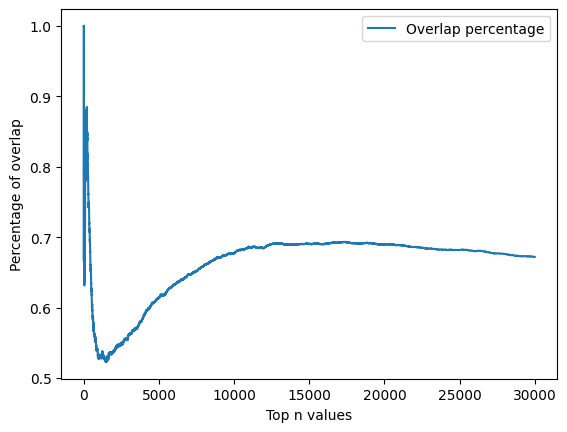

In [32]:
plt.subplot(1, 1, 1)
steps = np.arange(1, len(similarity_list)+1, 1)
similarity_list = np.array(similarity_list)
plt.plot(steps, (similarity_list/steps), label='Overlap percentage')

plt.xlabel("Top n values")
plt.ylabel("Percentage of overlap")

# plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
# plt.title(f'Using optimizer with learning rate {lr}')
plt.show

In [33]:
top_layers_sum = print_layers_with_top_values(sorted_indices_sum, top_n, position_to_layer_id, id_to_layer)

{'decoder.block.7.layer.1.EncDecAttention.q.weight': 1480, 'decoder.block.7.layer.0.SelfAttention.q.weight': 1388, 'lm_head.weight': 1308, 'decoder.block.5.layer.0.SelfAttention.q.weight': 1190, 'decoder.block.6.layer.1.EncDecAttention.q.weight': 1150, 'decoder.block.6.layer.0.SelfAttention.q.weight': 1079, 'decoder.block.7.layer.2.layer_norm.weight': 512, 'decoder.block.7.layer.1.layer_norm.weight': 512, 'encoder.final_layer_norm.weight': 512, 'encoder.block.4.layer.1.layer_norm.weight': 512, 'encoder.block.3.layer.1.layer_norm.weight': 512, 'encoder.block.0.layer.0.layer_norm.weight': 512, 'encoder.block.5.layer.1.layer_norm.weight': 512, 'encoder.block.2.layer.1.layer_norm.weight': 512, 'decoder.block.0.layer.2.layer_norm.weight': 512, 'decoder.block.1.layer.2.layer_norm.weight': 512, 'encoder.block.1.layer.0.layer_norm.weight': 512, 'decoder.block.2.layer.2.layer_norm.weight': 512, 'encoder.block.0.layer.1.layer_norm.weight': 512, 'decoder.block.6.layer.2.layer_norm.weight': 511, '

In [34]:
top_layers_tran = print_layers_with_top_values(sorted_indices_tran, top_n, position_to_layer_id, id_to_layer)


{'decoder.block.7.layer.0.SelfAttention.q.weight': 3348, 'decoder.block.5.layer.0.SelfAttention.q.weight': 1540, 'decoder.block.7.layer.1.EncDecAttention.q.weight': 1480, 'decoder.block.6.layer.0.SelfAttention.q.weight': 881, 'encoder.block.3.layer.0.SelfAttention.q.weight': 784, 'decoder.block.7.layer.2.DenseReluDense.wi_0.weight': 680, 'encoder.block.2.layer.0.SelfAttention.q.weight': 591, 'decoder.block.7.layer.2.layer_norm.weight': 512, 'encoder.block.1.layer.0.layer_norm.weight': 512, 'encoder.final_layer_norm.weight': 512, 'encoder.block.2.layer.1.layer_norm.weight': 512, 'decoder.block.1.layer.2.layer_norm.weight': 512, 'encoder.block.0.layer.0.layer_norm.weight': 512, 'encoder.block.1.layer.1.layer_norm.weight': 512, 'decoder.block.2.layer.2.layer_norm.weight': 512, 'encoder.block.0.layer.1.layer_norm.weight': 512, 'decoder.block.0.layer.2.layer_norm.weight': 512, 'decoder.block.0.layer.0.layer_norm.weight': 512, 'encoder.block.4.layer.1.layer_norm.weight': 511, 'decoder.final_

In [35]:
no_in_encoder, no_in_decoder = 0, 0
for k in top_layers_sum.keys():
    if "encoder" in k:
        no_in_encoder += top_layers_sum[k]
    elif "decoder" in k:
        no_in_decoder += top_layers_sum[k]
print(f"Number of top N of Summary in encoder is {no_in_encoder}, decoder is {no_in_decoder}")


Number of top N of Summary in encoder is 10746, decoder is 17946


In [36]:
no_in_encoder, no_in_decoder = 0, 0
for k in top_layers_tran.keys():
    if "encoder" in k:
        no_in_encoder += top_layers_tran[k]
    elif "decoder" in k:
        no_in_decoder += top_layers_tran[k]
print(f"Number of top N of Translation in encoder is {no_in_encoder}, decoder is {no_in_decoder}")

Number of top N of Translation in encoder is 10208, decoder is 19290


In [52]:
for m in model.parameters():
    print(m.shape)

torch.Size([32128, 512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([512, 384])
torch.Size([32, 6])
torch.Size([512])
torch.Size([1024, 512])
torch.Size([1024, 512])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([512, 384])
torch.Size([512])
torch.Size([1024, 512])
torch.Size([1024, 512])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([512, 384])
torch.Size([512])
torch.Size([1024, 512])
torch.Size([1024, 512])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([512, 384])
torch.Size([512])
torch.Size([1024, 512])
torch.Size([1024, 512])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([384, 512])
torch.Size([512, 384])
torch.Size([512])
torch.Size([1024, 512])
torch.Size([1024, 512

In [44]:
model.state_dict()

OrderedDict([('shared.weight',
              tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
                       -5.0757e-01,  4.1380e+00],
                      [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
                        6.3581e+00,  9.9587e+01],
                      [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
                        1.1030e+01,  1.8525e+01],
                      ...,
                      [-4.5117e-01, -3.3594e-01, -3.8867e-01,  ..., -2.0996e-01,
                       -2.0000e+00, -9.1406e-01],
                      [-1.0234e+00, -8.0859e-01,  4.3555e-01,  ..., -5.9326e-02,
                       -9.2188e-01, -9.2969e-01],
                      [ 1.0078e+00,  1.5234e-01, -2.4902e-01,  ..., -1.8555e-01,
                       -2.7148e-01,  1.7969e+00]], device='cuda:0')),
             ('encoder.embed_tokens.weight',
              tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
          

In [55]:
flat_model_sum = flatten_params(model.state_dict())

In [47]:
flat_model_sum

{'params': tensor([[ 3.0904],
         [ 0.1937],
         [-0.2758],
         ...,
         [ 0.2397],
         [-2.1929],
         [-3.7084]], device='cuda:0'),
 'indices': [(0, 16449536),
  (16449536, 32899072),
  (32899072, 33095680),
  (33095680, 33292288),
  (33292288, 33488896),
  (33488896, 33685504),
  (33685504, 33685696),
  (33685696, 33686208),
  (33686208, 34210496),
  (34210496, 34734784),
  (34734784, 35259072),
  (35259072, 35259584),
  (35259584, 35456192),
  (35456192, 35652800),
  (35652800, 35849408),
  (35849408, 36046016),
  (36046016, 36046528),
  (36046528, 36570816),
  (36570816, 37095104),
  (37095104, 37619392),
  (37619392, 37619904),
  (37619904, 37816512),
  (37816512, 38013120),
  (38013120, 38209728),
  (38209728, 38406336),
  (38406336, 38406848),
  (38406848, 38931136),
  (38931136, 39455424),
  (39455424, 39979712),
  (39979712, 39980224),
  (39980224, 40176832),
  (40176832, 40373440),
  (40373440, 40570048),
  (40570048, 40766656),
  (40766656, 4076

In [69]:
flat_model_sum["params"][1][0] = 1.5

In [79]:
model_sum_recovered = recover_flattened(flat_model_sum["params"], flat_model_sum["indices"], model.state_dict())

In [80]:
model_sum_recovered 

[tensor([[ 3.0904e+00,  1.5000e+00, -2.7579e-01,  ...,  5.0314e-01,
          -5.0757e-01,  4.1380e+00],
         [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
           6.3581e+00,  9.9587e+01],
         [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
           1.1030e+01,  1.8525e+01],
         ...,
         [-4.5117e-01, -3.3594e-01, -3.8867e-01,  ..., -2.0996e-01,
          -2.0000e+00, -9.1406e-01],
         [-1.0234e+00, -8.0859e-01,  4.3555e-01,  ..., -5.9326e-02,
          -9.2188e-01, -9.2969e-01],
         [ 1.0078e+00,  1.5234e-01, -2.4902e-01,  ..., -1.8555e-01,
          -2.7148e-01,  1.7969e+00]], device='cuda:0'),
 tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
          -5.0757e-01,  4.1380e+00],
         [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
           6.3581e+00,  9.9587e+01],
         [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
           1.1030e+01,  1.8525e+01],
         ...,
        

In [104]:
dict(zip(model.state_dict().keys(), model_sum_recovered))

{'shared.weight': tensor([[ 3.0904e+00,  1.5000e+00, -2.7579e-01,  ...,  5.0314e-01,
          -5.0757e-01,  4.1380e+00],
         [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
           6.3581e+00,  9.9587e+01],
         [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
           1.1030e+01,  1.8525e+01],
         ...,
         [-4.5117e-01, -3.3594e-01, -3.8867e-01,  ..., -2.0996e-01,
          -2.0000e+00, -9.1406e-01],
         [-1.0234e+00, -8.0859e-01,  4.3555e-01,  ..., -5.9326e-02,
          -9.2188e-01, -9.2969e-01],
         [ 1.0078e+00,  1.5234e-01, -2.4902e-01,  ..., -1.8555e-01,
          -2.7148e-01,  1.7969e+00]], device='cuda:0'),
 'encoder.embed_tokens.weight': tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
          -5.0757e-01,  4.1380e+00],
         [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
           6.3581e+00,  9.9587e+01],
         [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
           

In [102]:
config = AutoConfig.from_pretrained(model_small, state_dict = dict(zip(model.state_dict().keys(), model_sum_recovered)))

m = AutoModelForSeq2SeqLM.from_pretrained(None, state_dict=dict(zip(model.state_dict().keys(), model_sum_recovered)),  config=config)
# m.load_state_dict(dict(zip(model.state_dict().keys(), model_sum_recovered)))

In [105]:
m.state_dict() 

OrderedDict([('shared.weight',
              tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
                       -5.0757e-01,  4.1380e+00],
                      [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
                        6.3581e+00,  9.9587e+01],
                      [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
                        1.1030e+01,  1.8525e+01],
                      ...,
                      [-4.5117e-01, -3.3594e-01, -3.8867e-01,  ..., -2.0996e-01,
                       -2.0000e+00, -9.1406e-01],
                      [-1.0234e+00, -8.0859e-01,  4.3555e-01,  ..., -5.9326e-02,
                       -9.2188e-01, -9.2969e-01],
                      [ 1.0078e+00,  1.5234e-01, -2.4902e-01,  ..., -1.8555e-01,
                       -2.7148e-01,  1.7969e+00]])),
             ('encoder.embed_tokens.weight',
              tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
                       -5.0

In [107]:
m = AutoModel._load_state_dict_into_model(m, state_dict = dict(zip(model.state_dict().keys(), model_sum_recovered)))

AttributeError: type object 'AutoModel' has no attribute '_load_state_dict_into_model'

In [77]:
model_sum_recovered  = AutoModelForSeq2SeqLM.from_pretrained(model_small, local_files_only=True, state_dict=dict(zip(model.state_dict().keys(), model_sum_recovered)))

In [78]:
model_sum_recovered.state_dict()

OrderedDict([('shared.weight',
              tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
                       -5.0757e-01,  4.1380e+00],
                      [-9.0601e+00,  9.5172e+00, -5.6732e-01,  ...,  1.2307e+01,
                        6.3581e+00,  9.9587e+01],
                      [ 7.4962e+00,  3.0095e+00, -4.2048e+00,  ..., -6.2926e+00,
                        1.1030e+01,  1.8525e+01],
                      ...,
                      [-4.5117e-01, -3.3594e-01, -3.8867e-01,  ..., -2.0996e-01,
                       -2.0000e+00, -9.1406e-01],
                      [-1.0234e+00, -8.0859e-01,  4.3555e-01,  ..., -5.9326e-02,
                       -9.2188e-01, -9.2969e-01],
                      [ 1.0078e+00,  1.5234e-01, -2.4902e-01,  ..., -1.8555e-01,
                       -2.7148e-01,  1.7969e+00]])),
             ('encoder.embed_tokens.weight',
              tensor([[ 3.0904e+00,  1.9374e-01, -2.7579e-01,  ...,  5.0314e-01,
                       -5.0

In [2]:
class Parameter:
    def __init__(self, value, layer, index):
        self.value = value
        self.index = index
        self.layer = layer
    def __lt__(self, other):
        return self.value < other.value

In [30]:
def count_parameters(model):
    c = 0
    for k, v in model.items():
        if len(v.shape) == 1:
            c += len(v)
        else:
            c += len(v) * len(v[0])
    return c

In [32]:
no_parameters = count_parameters(ewc_race_sum._precision_matrices)

In [39]:
import heapq
from tqdm import tqdm
heap_len = 10000
top_n_members = []
print(top_n_members)
progress_bar = tqdm(range(no_parameters))
for k,v  in ewc_race_sum._precision_matrices.items():
    for r, r_value in enumerate(v):
        p = None
        if len(v.shape) == 1:
            p = Parameter(r_value, k, [r])
            if len(top_n_members) < heap_len:
                heapq.heappush(top_n_members, p)
            else:
                if top_n_members[0] < p:
                    heapq.heappushpop(top_n_members, p)
            progress_bar.update(1)
                    
        elif len(v.shape) == 2:
            for c, c_value in enumerate(r_value):
                p = Parameter(c_value, k, [r, c])
                if len(top_n_members) < heap_len:
                    heapq.heappush(top_n_members, p)
                    # print(p.value)
                else:
                    if top_n_members[0] < p:
                        heapq.heappushpop(top_n_members, p)
                progress_bar.update(1)
                
        else:
            raise ValueError
            


[]


100%|█████████████████████████▉| 76960394/76961152 [1:24:11<00:00, 13989.69it/s]

In [42]:
# with open("/scratches/dialfs/alta/hln35/distillation/top_n_ewc_after_summary.txt", "wb") as fp:
#     pickle.dump(top_n_members, fp)

In [41]:
len(top_n_members)

10000

In [47]:
print(top_n_members[0].value)
print(top_n_members[0].layer)


tensor(3.2944, device='cuda:0')
decoder.block.2.layer.2.layer_norm.weight


In [48]:
print(top_n_members[1].value)
print(top_n_members[1].layer)


tensor(3.2947, device='cuda:0')
decoder.block.3.layer.0.layer_norm.weight


In [46]:
print(top_n_members[9999].value)
print(top_n_members[9999].layer)


tensor(13.5659, device='cuda:0')
encoder.block.3.layer.1.layer_norm.weight


In [50]:
# with open("/scratches/dialfs/alta/hln35/distillation/top_n_ewc_after_summary_5000.txt", "wb") as fp:
#     pickle.dump(top_n_members[5000:], fp)

In [51]:
print("a")


a


In [ ]:
heap_len = 5000
top_n_members_cp = []
print(top_n_members_cp)
progress_bar = tqdm(range(no_parameters))
for k,v  in ewc_race_tran._precision_matrices.items():
    for r, r_value in enumerate(v):
        p = None
        if len(v.shape) == 1:
            p = Parameter(r_value, k, [r])
            if len(top_n_members_cp) < heap_len:
                heapq.heappush(top_n_members_cp, p)
            else:
                if top_n_members_cp[0] < p:
                    heapq.heappushpop(top_n_members_cp, p)
            progress_bar.update(1)
        elif len(v.shape) == 2:
            for c, c_value in enumerate(r_value):
                p = Parameter(c_value, k, [r, c])
                if len(top_n_members_cp) < heap_len:
                    heapq.heappush(top_n_members_cp, p)
                    # print(p.value)
                else:
                    if top_n_members_cp[0] < p:
                        heapq.heappushpop(top_n_members_cp, p)
                progress_bar.update(1)
                
        else:
            raise ValueError

[]



100%|███████████████████████████| 76961152/76961152 [2:53:19<00:00, 7400.59it/s]

 86%|████████████████████████▏   | 66523659/76961152 [42:33<04:40, 37225.41it/s]


In [3]:
with open("/scratches/dialfs/alta/hln35/distillation/top_n_ewc_after_summary_5000.txt", "rb") as fp:
    top_n_sum = pickle.load(fp)
with open("/scratches/dialfs/alta/hln35/distillation/top_n_ewc_after_tran_5000.txt", "rb") as fp:
    top_n_tran = pickle.load(fp)



In [4]:
top_n_in_layers_sum, top_n_in_layers_tran = {}, {}
for p in top_n_sum:
    if p.layer in top_n_in_layers_sum:
        top_n_in_layers_sum[p.layer] += 1
    else:
        top_n_in_layers_sum[p.layer] = 1
for p in top_n_tran:
    if p.layer in top_n_in_layers_tran:
        top_n_in_layers_tran[p.layer] += 1
    else:
        top_n_in_layers_tran[p.layer] = 1
        

In [5]:
top_n_in_layers_sum = dict(sorted(top_n_in_layers_sum.items()))
top_n_in_layers_tran = dict(sorted(top_n_in_layers_tran.items()))


In [6]:
top_n_in_layers_sum

{'decoder.block.0.layer.0.layer_norm.weight': 35,
 'decoder.block.0.layer.1.EncDecAttention.q.weight': 3,
 'decoder.block.0.layer.1.layer_norm.weight': 12,
 'decoder.block.0.layer.2.layer_norm.weight': 241,
 'decoder.block.1.layer.0.layer_norm.weight': 22,
 'decoder.block.1.layer.1.layer_norm.weight': 11,
 'decoder.block.1.layer.2.layer_norm.weight': 83,
 'decoder.block.2.layer.0.layer_norm.weight': 18,
 'decoder.block.2.layer.1.EncDecAttention.q.weight': 9,
 'decoder.block.2.layer.1.layer_norm.weight': 8,
 'decoder.block.2.layer.2.layer_norm.weight': 60,
 'decoder.block.3.layer.0.SelfAttention.q.weight': 5,
 'decoder.block.3.layer.0.layer_norm.weight': 17,
 'decoder.block.3.layer.1.EncDecAttention.q.weight': 6,
 'decoder.block.3.layer.1.layer_norm.weight': 10,
 'decoder.block.3.layer.2.layer_norm.weight': 16,
 'decoder.block.4.layer.0.SelfAttention.q.weight': 15,
 'decoder.block.4.layer.0.layer_norm.weight': 13,
 'decoder.block.4.layer.1.EncDecAttention.q.weight': 3,
 'decoder.block.4

In [7]:
top_n_in_layers_tran

{'decoder.block.0.layer.0.layer_norm.weight': 38,
 'decoder.block.0.layer.1.layer_norm.weight': 3,
 'decoder.block.0.layer.2.layer_norm.weight': 319,
 'decoder.block.1.layer.0.layer_norm.weight': 24,
 'decoder.block.1.layer.1.EncDecAttention.q.weight': 2,
 'decoder.block.1.layer.1.layer_norm.weight': 9,
 'decoder.block.1.layer.2.layer_norm.weight': 104,
 'decoder.block.2.layer.0.SelfAttention.q.weight': 1,
 'decoder.block.2.layer.0.layer_norm.weight': 18,
 'decoder.block.2.layer.1.EncDecAttention.q.weight': 7,
 'decoder.block.2.layer.1.layer_norm.weight': 9,
 'decoder.block.2.layer.2.layer_norm.weight': 52,
 'decoder.block.3.layer.0.SelfAttention.q.weight': 3,
 'decoder.block.3.layer.0.layer_norm.weight': 16,
 'decoder.block.3.layer.1.layer_norm.weight': 8,
 'decoder.block.3.layer.2.layer_norm.weight': 15,
 'decoder.block.4.layer.0.SelfAttention.q.weight': 12,
 'decoder.block.4.layer.0.layer_norm.weight': 12,
 'decoder.block.4.layer.1.layer_norm.weight': 8,
 'decoder.block.4.layer.2.la

In [11]:
top_n_sum_filter = {p: top_n_in_layers_sum[p] for p in top_n_in_layers_sum if top_n_in_layers_sum[p] > 100}
top_n_tran_filter = {p: top_n_in_layers_tran[p] for p in top_n_in_layers_tran if top_n_in_layers_tran[p] > 100}


In [12]:
top_n_sum_filter

{'decoder.block.0.layer.2.layer_norm.weight': 241,
 'decoder.block.7.layer.0.SelfAttention.q.weight': 123,
 'decoder.block.7.layer.2.layer_norm.weight': 287,
 'decoder.final_layer_norm.weight': 495,
 'encoder.block.0.layer.0.layer_norm.weight': 381,
 'encoder.block.0.layer.1.layer_norm.weight': 396,
 'encoder.block.1.layer.0.layer_norm.weight': 169,
 'encoder.block.1.layer.1.layer_norm.weight': 216,
 'encoder.block.2.layer.0.layer_norm.weight': 108,
 'encoder.block.2.layer.1.layer_norm.weight': 169,
 'encoder.block.3.layer.1.layer_norm.weight': 175,
 'encoder.block.4.layer.1.layer_norm.weight': 123,
 'encoder.block.7.layer.1.layer_norm.weight': 197,
 'encoder.final_layer_norm.weight': 430,
 'lm_head.weight': 253}

In [13]:
top_n_tran_filter

{'decoder.block.0.layer.2.layer_norm.weight': 319,
 'decoder.block.1.layer.2.layer_norm.weight': 104,
 'decoder.block.6.layer.2.layer_norm.weight': 107,
 'decoder.block.7.layer.0.SelfAttention.q.weight': 276,
 'decoder.block.7.layer.2.layer_norm.weight': 237,
 'decoder.final_layer_norm.weight': 486,
 'encoder.block.0.layer.0.layer_norm.weight': 425,
 'encoder.block.0.layer.1.layer_norm.weight': 379,
 'encoder.block.1.layer.0.layer_norm.weight': 243,
 'encoder.block.1.layer.1.layer_norm.weight': 278,
 'encoder.block.2.layer.0.layer_norm.weight': 197,
 'encoder.block.2.layer.1.layer_norm.weight': 220,
 'encoder.block.3.layer.1.layer_norm.weight': 193,
 'encoder.block.4.layer.1.layer_norm.weight': 122,
 'encoder.final_layer_norm.weight': 288,
 'lm_head.weight': 126}

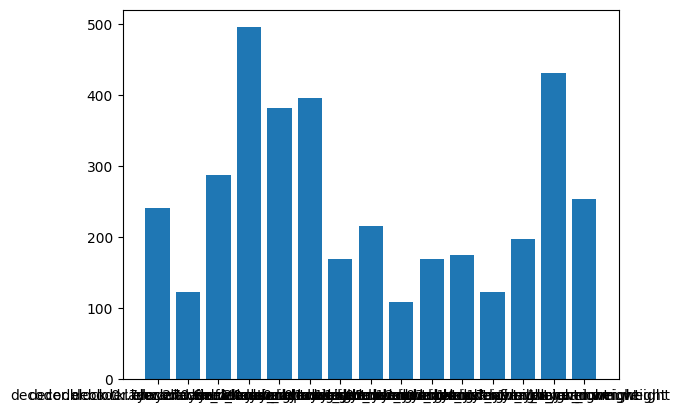

In [14]:
import matplotlib.pyplot as plt


plt.bar(range(len(top_n_sum_filter)), list(top_n_sum_filter.values()), align='center')
plt.xticks(range(len(top_n_sum_filter)), list(top_n_sum_filter.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

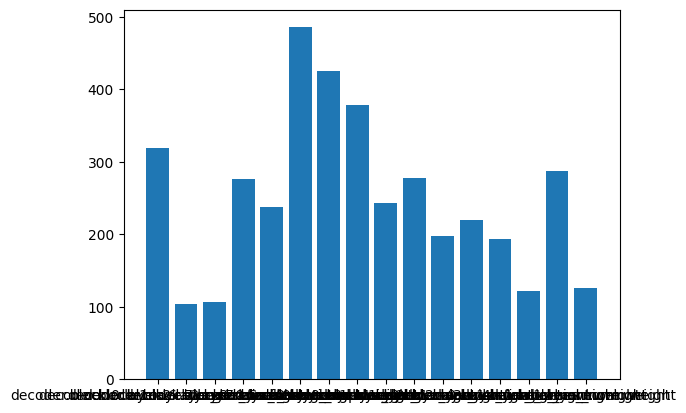

In [15]:
plt.bar(range(len(top_n_tran_filter)), list(top_n_tran_filter.values()), align='center')
plt.xticks(range(len(top_n_tran_filter)), list(top_n_tran_filter.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

In [28]:
top_n_sum_set = {(p.layer, tuple(p.index)) for p in top_n_sum}
top_n_tran_set = {(p.layer, tuple(p.index)) for p in top_n_tran}


In [27]:
top_n_sum_set

{('encoder.final_layer_norm.weight', (241,)),
 ('decoder.final_layer_norm.weight', (63,)),
 ('decoder.final_layer_norm.weight', (488,)),
 ('decoder.block.6.layer.0.layer_norm.weight', (247,)),
 ('encoder.block.0.layer.0.layer_norm.weight', (156,)),
 ('encoder.block.1.layer.1.layer_norm.weight', (419,)),
 ('encoder.block.1.layer.0.layer_norm.weight', (56,)),
 ('encoder.block.0.layer.0.SelfAttention.q.weight', (83, 511)),
 ('encoder.block.1.layer.0.layer_norm.weight', (481,)),
 ('encoder.block.0.layer.0.layer_norm.weight', (300,)),
 ('decoder.block.6.layer.2.DenseReluDense.wi_0.weight', (513, 456)),
 ('decoder.block.1.layer.2.layer_norm.weight', (221,)),
 ('encoder.block.2.layer.1.layer_norm.weight', (478,)),
 ('decoder.block.5.layer.2.layer_norm.weight', (101,)),
 ('encoder.block.0.layer.1.layer_norm.weight', (332,)),
 ('encoder.block.2.layer.0.layer_norm.weight', (127,)),
 ('encoder.final_layer_norm.weight', (453,)),
 ('decoder.block.5.layer.0.SelfAttention.q.weight', (343, 0)),
 ('dec

In [30]:
count_similarity = 0
layers_with_similarity = {}
for p in top_n_sum_set:
    if p in top_n_tran_set:
        count_similarity += 1
        if p[0] in layers_with_similarity:
            layers_with_similarity[p[0]] += 1
        else:
            layers_with_similarity[p[0]] = 1
            
print(f"Similar in 2 top 5000 values is {count_similarity}")

Similar in 2 top 5000 values is 2911


In [34]:
layers_with_similarity = dict(sorted(layers_with_similarity.items(), key=lambda item: -item[1]))
layers_with_similarity

{'decoder.final_layer_norm.weight': 472,
 'encoder.block.0.layer.0.layer_norm.weight': 322,
 'encoder.block.0.layer.1.layer_norm.weight': 302,
 'encoder.final_layer_norm.weight': 250,
 'decoder.block.0.layer.2.layer_norm.weight': 173,
 'decoder.block.7.layer.2.layer_norm.weight': 159,
 'encoder.block.1.layer.1.layer_norm.weight': 145,
 'encoder.block.3.layer.1.layer_norm.weight': 107,
 'encoder.block.1.layer.0.layer_norm.weight': 102,
 'encoder.block.2.layer.1.layer_norm.weight': 95,
 'decoder.block.7.layer.0.SelfAttention.q.weight': 71,
 'lm_head.weight': 67,
 'encoder.block.2.layer.0.layer_norm.weight': 62,
 'encoder.block.4.layer.1.layer_norm.weight': 52,
 'decoder.block.1.layer.2.layer_norm.weight': 44,
 'encoder.block.7.layer.1.layer_norm.weight': 37,
 'decoder.block.5.layer.0.SelfAttention.q.weight': 25,
 'decoder.block.7.layer.1.EncDecAttention.q.weight': 24,
 'decoder.block.2.layer.2.layer_norm.weight': 23,
 'decoder.block.0.layer.0.layer_norm.weight': 23,
 'encoder.block.3.lay

In [35]:
def compare_2_model(model1, model2):
    top_n_sum_set = {(p.layer, tuple(p.index)) for p in model1}
    top_n_tran_set = {(p.layer, tuple(p.index)) for p in model2}
    count_similarity = 0
    layers_with_similarity = {}
    for p in top_n_sum_set:
        if p in top_n_tran_set:
            count_similarity += 1
            if p[0] in layers_with_similarity:
                layers_with_similarity[p[0]] += 1
            else:
                layers_with_similarity[p[0]] = 1
                
    print(f"Similar in 2 top {len(model1)} values is {count_similarity}")
    layers_with_similarity = dict(sorted(layers_with_similarity.items(), key=lambda item: -item[1]))
    print("Similarity at each layer")
    print(layers_with_similarity)


In [36]:
compare_2_model(top_n_sum[-1000:], top_n_tran[-1000:])

Similar in 2 top 1000 values is 123
Similarity at each layer
{'decoder.final_layer_norm.weight': 27, 'encoder.block.0.layer.0.layer_norm.weight': 16, 'decoder.block.7.layer.2.layer_norm.weight': 9, 'encoder.block.0.layer.1.layer_norm.weight': 8, 'encoder.block.1.layer.1.layer_norm.weight': 6, 'encoder.final_layer_norm.weight': 6, 'lm_head.weight': 5, 'encoder.block.1.layer.0.layer_norm.weight': 5, 'encoder.block.4.layer.1.layer_norm.weight': 4, 'encoder.block.3.layer.1.layer_norm.weight': 4, 'decoder.block.2.layer.0.layer_norm.weight': 3, 'decoder.block.0.layer.2.layer_norm.weight': 3, 'decoder.block.4.layer.2.layer_norm.weight': 2, 'decoder.block.7.layer.1.EncDecAttention.q.weight': 2, 'decoder.block.1.layer.2.layer_norm.weight': 2, 'decoder.block.2.layer.2.layer_norm.weight': 2, 'encoder.block.3.layer.0.layer_norm.weight': 2, 'decoder.block.4.layer.0.layer_norm.weight': 2, 'encoder.block.2.layer.0.layer_norm.weight': 2, 'decoder.block.6.layer.1.layer_norm.weight': 1, 'decoder.block.7

In [37]:
compare_2_model(top_n_sum[-100:], top_n_tran[-100:])


Similar in 2 top 100 values is 4
Similarity at each layer
{'decoder.block.7.layer.2.layer_norm.weight': 2, 'encoder.block.4.layer.1.layer_norm.weight': 1, 'encoder.block.0.layer.0.layer_norm.weight': 1}
